## 1. Introducción

**Objetivo:** Entrenar un modelo de *deep learning* para clasificar imágenes en **6 categorías** de escenas naturales: *buildings, forest, glacier, mountain, sea, street*.  
El modelo recibe una imagen de entrada y predice a qué clase pertenece, resolviendo un problema de clasificación multiclase.

**Relevancia:**  
La clasificación automática de escenas tiene aplicaciones en indexación de contenidos, análisis multimedia, georreferenciación contextual, turismo inteligente y sistemas de visión en robótica. Es una tarea real y más compleja que los datasets clásicos como MNIST o CIFAR-10, ya que las escenas presentan mayor variabilidad de iluminación, fondo, texturas y composición.

**Dataset:**  
Se utiliza el dataset **Intel Image Classification (Kaggle)**, el cual contiene miles de imágenes a color de tamaño variable distribuidas en 6 clases balanceadas. Este dataset no es de tipo *toy*, pues posee variedad de condiciones y una cantidad considerable de muestras, haciendo necesario el uso de redes convolucionales profundas.

Link del dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

Link de la carpeta de los datos en Drive:https://drive.google.com/drive/folders/1DTZ3XiD3efs-_cmXIs3_ielesAEYEuOQ?usp=sharing

Se debe de descargar la data para poder correr el código

**Técnicas empleadas:**
- **CNN** como arquitectura base para extracción de características.
- **Squeeze-and-Excitation** (SE) en el Modelo V2 para recalibración de canales.
- **Transfer Learning (ResNet50)** en el Modelo V3 para reutilizar conocimiento aprendido en *ImageNet*.
- **Batch Normalization** para estabilizar el entrenamiento.
- **Dropout** como regularización para reducir sobreajuste.
- **Callbacks** (EarlyStopping, ModelCheckpoint) para optimizar entrenamiento.
- **Evaluación** con reporte de clasificación, matriz de confusión y accuracy.

El objetivo final es obtener un modelo que generalice correctamente sobre imágenes no vistas.



## 2. Datos

**Fuente:** Kaggle — *Intel Image Classification*  
https://www.kaggle.com/puneet6060/intel-image-classification

El dataset contiene **24,353 imágenes** divididas en tres carpetas:
- seg_train/ → entrenamiento  
- seg_test/ → prueba  
- seg_pred/ → predicciones opcionales

Cada imagen pertenece a una de las siguientes clases:
**buildings, forest, glacier, mountain, sea, street.**


In [1]:
from pathlib import Path
import os, random, numpy as np

# Reproducibilidad
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Rutas
DATASET_BASE = Path("./data")
TRAIN_DIR = DATASET_BASE / "seg_train"
TEST_DIR  = DATASET_BASE / "seg_test"

print("Train:", TRAIN_DIR.resolve())
print("Test :", TEST_DIR.resolve())
print("Clases:", sorted(os.listdir(TRAIN_DIR)))

# Parámetros globales
IMG_SIZE_V1V2   = (150, 150)  
IMG_SIZE_V3    = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT  = 0.20

# Carpeta de modelos
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)



Train: C:\Users\KALED\OneDrive\Documentos\deep_learning\data\seg_train
Test : C:\Users\KALED\OneDrive\Documentos\deep_learning\data\seg_test
Clases: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## 3. Preprocesamiento

Se utilizarán generadores de imágenes (ImageDataGenerator) para:
- Escalar los valores de píxeles a [0,1].
- Separar automáticamente los conjuntos de **entrenamiento y validación** (80%-20%).
- Aplicar *Data Augmentation* opcional en la segunda versión del modelo.


El segundo modelo se utiliza pytorch como backend, ya que TensorFlow dejó de dar soporte a GPUs en Windows lo que relentiza el entrenamiento de la red. Sin embargo, pytorch detecta de buena forma mi GPU y puedo entrenar más rápido. 

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE_V1V2 = (150, 150)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

# Generador base sin aumento (para V1 y V2)
train_datagen_v1 = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)

train_gen_v1 = train_datagen_v1.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE_V1V2, batch_size=BATCH_SIZE,
    subset='training', seed=SEED
)
val_gen_v1 = train_datagen_v1.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE_V1V2, batch_size=BATCH_SIZE,
    subset='validation', seed=SEED
)
val_gen_v2 = val_gen_v1
train_gen_v2 = train_gen_v1
class_indices = train_gen_v1.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
class_indices




Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

IMG_SIZE_V3 = (224, 224)  # recomendado para ResNet50

# Generadores SOLO para V3
train_datagen_v3 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT,
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen_v3 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT
)

train_gen_v3 = train_datagen_v3.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V3,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED
)
val_gen_v3 = val_datagen_v3.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V3,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=SEED
)
num_classes = train_gen_v3.num_classes


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


### 4. Visualización

Se muestran imágenes aleatorias del conjunto de entrenamiento junto con sus etiquetas para verificar la correcta lectura de clases y normalización.


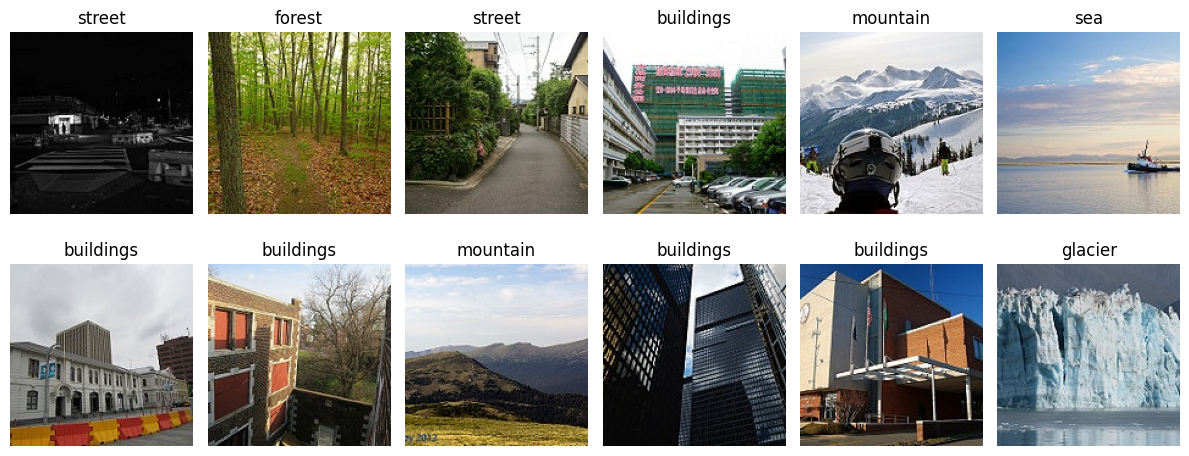

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_batch(generator, n=12):
    x, y = next(generator)
    n = min(n, x.shape[0])
    cols = 6
    rows = math.ceil(n / cols)
    plt.figure(figsize=(12, 2.5*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x[i])
        plt.title(list(generator.class_indices.keys())[np.argmax(y[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_batch(train_gen_v1, n=12)


## 5. Modelo V1 — CNN Base

**Arquitectura:**
- 3 bloques: Conv2D + ReLU + MaxPooling2D
- Flatten → Dense(128, ReLU) → Dropout(0.5)
- Capa de salida: Dense(num_classes, softmax)

**Técnicas:**
- Dropout(0.5) como regularización
- Optimizador: Adam
- Función de pérdida: categorical_crossentropy
- Métrica: accuracy


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_v1 = models.Sequential([
    layers.Input(shape=(*IMG_SIZE_V1V2, 3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128,3, activation='relu'), layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
model_v1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_v1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo

Se usan **callbacks** para mejorar la eficiencia:
- *EarlyStopping*: detiene el entrenamiento si no mejora.
- *ModelCheckpoint*: guarda el mejor modelo.


In [55]:
callbacks_v1 = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=str(MODELS_DIR / 'scene_v1.keras'), monitor='val_accuracy', save_best_only=True)
]

history_v1 = model_v1.fit(
    train_gen_v1,
    epochs=20,
    validation_data=val_gen_v1,
    callbacks=callbacks_v1
)


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.5654 - loss: 1.1150 - val_accuracy: 0.7208 - val_loss: 0.8002
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 146ms/step - accuracy: 0.7046 - loss: 0.8147 - val_accuracy: 0.7764 - val_loss: 0.6229
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 146ms/step - accuracy: 0.7537 - loss: 0.6892 - val_accuracy: 0.7803 - val_loss: 0.5856
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.7904 - loss: 0.5853 - val_accuracy: 0.8003 - val_loss: 0.5588
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.8213 - loss: 0.5028 - val_accuracy: 0.8149 - val_loss: 0.5323
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.8377 - loss: 0.4471 - val_accuracy: 0.8277 - val_loss: 0.5161
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.8581 - loss: 0.3840 - val_accuracy: 0.8067 - val_loss: 0.6135
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 141ms/step - accuracy: 0.8817 - loss: 0

### Análisis visual del entrenamiento
Las curvas de entrenamiento de *loss* y *accuracy* permiten observar el desempeño. Lo que nos sirve para ver si existe algún sobreajuste.

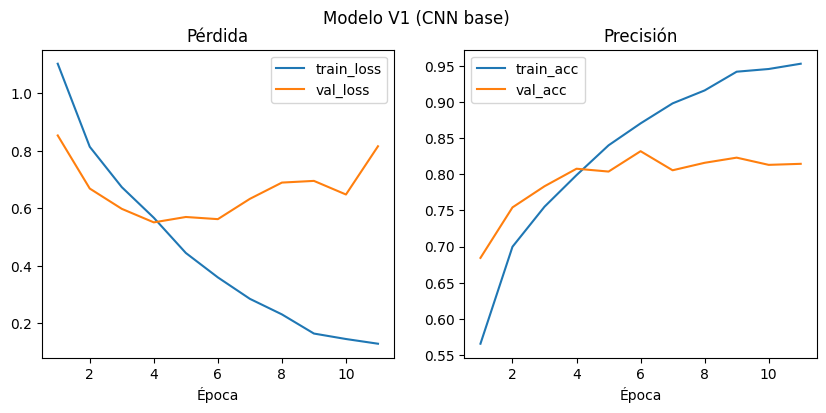

In [35]:
def plot_history(history, title='Histórico de entrenamiento'):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title('Pérdida'); plt.xlabel('Época'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], label='train_acc')
    plt.plot(epochs, hist['val_accuracy'], label='val_acc')
    plt.title('Precisión'); plt.xlabel('Época'); plt.legend()

    plt.suptitle(title)
    plt.show()

plot_history(history_v1, title='Modelo V1 (CNN base)')


## 8. Modelo V2 — CNN con Bloques Squeeze-and-Excitation

- Se añaden **bloques Squeeze-and-Excitation (SE)** para recalibrar canales y mejorar la representación de características.
- Se utiliza **BatchNorm** y **Dropout** como regularización para reducir sobreajuste.

In [12]:

import keras
from keras import layers, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Bloque SE (Squeeze-and-Excitation)
class SEBlock(layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
    def build(self, input_shape):
        channels = input_shape[-1]
        reduced = max(channels // self.reduction_ratio, 4)
        self.gap = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(reduced, activation="relu")
        self.fc2 = layers.Dense(channels, activation="sigmoid")
        self.reshape = layers.Reshape((1, 1, channels))
    def call(self, x):
        s = self.gap(x)
        s = self.fc1(s)
        s = self.fc2(s)
        s = self.reshape(s)
        return x * s

def build_model_with_se(input_shape, num_classes, se_ratio=16, drop=0.5):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = SEBlock(se_ratio)(x); x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = SEBlock(se_ratio)(x); x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = SEBlock(se_ratio)(x); x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Dropout(drop)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model_v2 = build_model_with_se(input_shape=(*IMG_SIZE_V1V2, 3), num_classes=num_classes)
model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_v2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 150, 150, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 150, 150, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_12 (SEBlock)           │ (None, 150, 150, 32)   │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 75, 75, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 75, 75, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_13 (SEBlock)           │ (None, 75, 75, 64)     │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 37, 37, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 37, 37, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 309,078 (1.18 MB)

 Trainable params: 307,926 (1.17 MB)

 Non-trainable params: 1,152 (4.50 KB)

### Entrenamiento del modelo

Se usan **callbacks** para mejorar la eficiencia:
- *EarlyStopping*: detiene el entrenamiento si no mejora.
- *ModelCheckpoint*: guarda el mejor modelo.

In [9]:
callbacks_v2 = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ModelCheckpoint(filepath=str(MODELS_DIR / 'model_v2_best.keras'), monitor='val_accuracy', save_best_only=True)
]

history_v2 = model_v2.fit(
    train_gen_v2,               
    epochs=20,
    validation_data=val_gen_v2, 
    callbacks=callbacks_v2
)

model_v2.save(MODELS_DIR / "model_v2_final.keras")


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 263ms/step - accuracy: 0.5630 - loss: 1.1203 - val_accuracy: 0.6013 - val_loss: 1.0394
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 91s 259ms/step - accuracy: 0.6990 - loss: 0.8040 - val_accuracy: 0.5175 - val_loss: 1.3225
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 91s 260ms/step - accuracy: 0.7532 - loss: 0.6612 - val_accuracy: 0.7129 - val_loss: 0.7280
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 91s 260ms/step - accuracy: 0.7838 - loss: 0.5964 - val_accuracy: 0.5417 - val_loss: 1.3757
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 123s 350ms/step - accuracy: 0.8015 - loss: 0.5454 - val_accuracy: 0.7022 - val_loss: 0.7255
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 102s 292ms/step - accuracy: 0.8183 - loss: 0.5154 - val_accuracy: 0.6106 - val_loss: 0.9640
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 103s 294ms/step - accuracy: 0.8285 - loss: 0.4828 - val_accuracy: 0.8627 - val_loss: 0.3955
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 121s 344ms/step - accuracy: 0.8380 - los

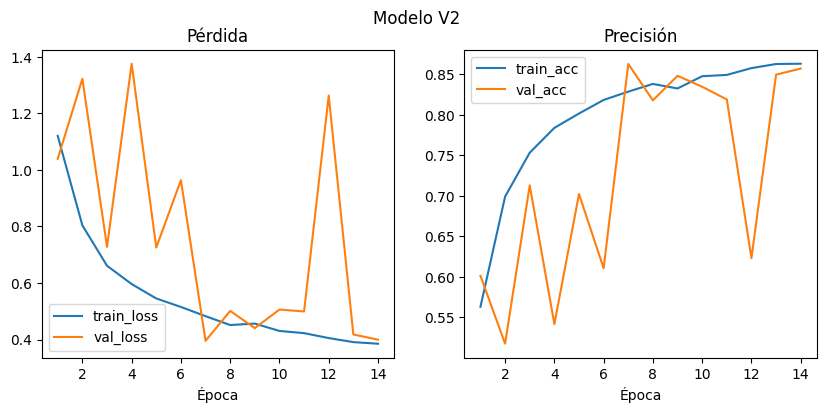

In [13]:
def plot_history(history, title='Histórico de entrenamiento'):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title('Pérdida'); plt.xlabel('Época'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], label='train_acc')
    plt.plot(epochs, hist['val_accuracy'], label='val_acc')
    plt.title('Precisión'); plt.xlabel('Época'); plt.legend()

    plt.suptitle(title)
    plt.show()

plot_history(history_v2, title='Modelo V2')

## 9. Modelo V3 — Transfer Learning con ResNet50

- Red base: **ResNet50** preentrenada en *ImageNet*.
- Cabeza densa con **BatchNorm** y **Dropout** para mejorar generalización.



In [13]:
# MODELO V3: Transfer Learning con ResNet50

import keras
from keras import layers, Model
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Base preentrenada en ImageNet
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE_V3, 3)
)

# Congelamos capas base para entrenar solo el header
base_model.trainable = False

# Header del modelo
inputs = layers.Input(shape=(*IMG_SIZE_V3, 3))
x = preprocess_input(inputs)                
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x) 
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_v3 = Model(inputs, outputs)
model_v3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_v3.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_46[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 6)         │      1,542 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,822 (91.99 MB)

 Trainable params: 526,598 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

### Entrenamiento del modelo

Se usan **callbacks** para mejorar la eficiencia:
- *EarlyStopping*: detiene el entrenamiento si no mejora.
- *ModelCheckpoint*: guarda el mejor modelo.

In [ ]:
callbacks_v3 = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=str(MODELS_DIR / "model_v3_best.keras"),
                    save_best_only=True, monitor='val_accuracy')
]

history_v3 = model_v3.fit(
    train_gen_v3,
    validation_data=val_gen_v3,
    epochs=12,
    callbacks=callbacks_v3
)

model_v3.save(MODELS_DIR / "model_v3_final.keras")

Epoch 1/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 161s 458ms/step - accuracy: 0.8747 - loss: 0.3523 - val_accuracy: 0.8912 - val_loss: 0.3083
Epoch 2/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 144s 411ms/step - accuracy: 0.8965 - loss: 0.2972 - val_accuracy: 0.8912 - val_loss: 0.3215
Epoch 3/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 173s 495ms/step - accuracy: 0.9015 - loss: 0.2744 - val_accuracy: 0.8969 - val_loss: 0.3007
Epoch 4/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 206s 588ms/step - accuracy: 0.9029 - loss: 0.2663 - val_accuracy: 0.8973 - val_loss: 0.2942
Epoch 5/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 181s 516ms/step - accuracy: 0.9069 - loss: 0.2535 - val_accuracy: 0.9016 - val_loss: 0.2752
Epoch 6/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 175s 499ms/step - accuracy: 0.9123 - loss: 0.2386 - val_accuracy: 0.9091 - val_loss: 0.2687
Epoch 7/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 178s 508ms/step - accuracy: 0.9163 - loss: 0.2331 - val_accuracy: 0.8998 - val_loss: 0.2856
Epoch 8/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 177s 506ms/step - accuracy: 0.9167 -

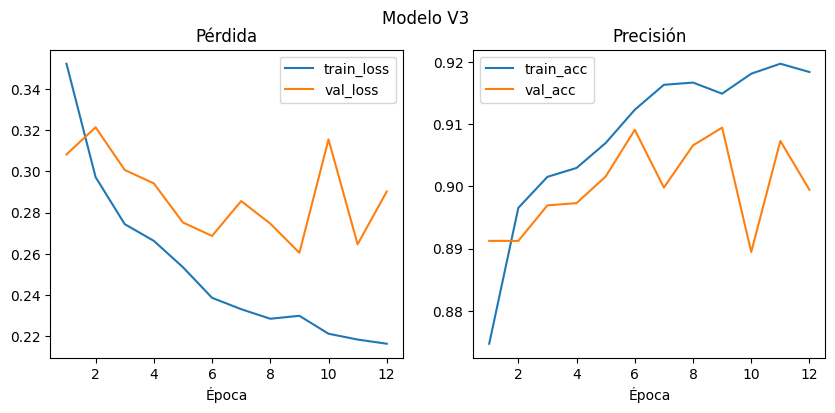

In [31]:
def plot_history(history, title='Histórico de entrenamiento'):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title('Pérdida'); plt.xlabel('Época'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], label='train_acc')
    plt.plot(epochs, hist['val_accuracy'], label='val_acc')
    plt.title('Precisión'); plt.xlabel('Época'); plt.legend()

    plt.suptitle(title)
    plt.show()

plot_history(history_v3, title='Modelo V3')

## 10. Evaluación Final

Los tres modelos desarrollados (V1, V2 y V3) son evaluados mediante un reporte de clasificación, matrices de confusión y el accuracy obtenido sobre los conjuntos de validación y prueba. Estas métricas permiten analizar el desempeño por clase, identificar errores frecuentes y verificar la capacidad de generalización del modelo.


Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

V1 (Validación)
              precision    recall  f1-score   support

   buildings       0.16      0.16      0.16       438
      forest       0.16      0.17      0.17       454
     glacier       0.20      0.17      0.19       480
    mountain       0.18      0.17      0.17       502
         sea       0.17      0.21      0.19       454
      street       0.15      0.15      0.15       476

    accuracy                           0.17      2804
   macro avg       0.17      0.17      0.17      2804
weighted avg       0.17      0.17      0.17      2804



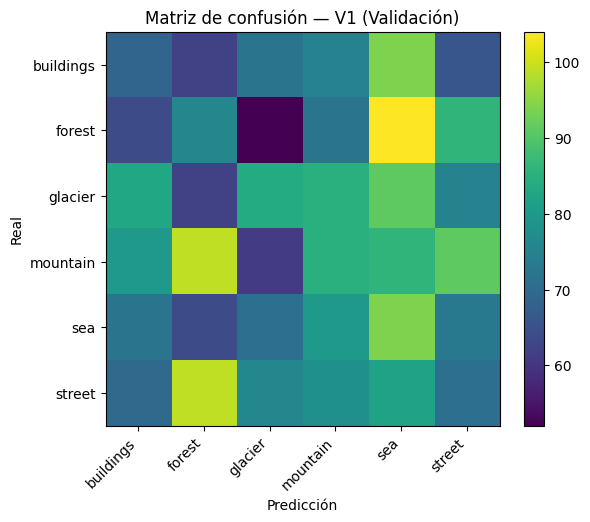


V2 (Validación)
              precision    recall  f1-score   support

   buildings       0.15      0.16      0.15       438
      forest       0.17      0.17      0.17       454
     glacier       0.16      0.15      0.15       480
    mountain       0.18      0.17      0.18       502
         sea       0.17      0.18      0.17       454
      street       0.18      0.18      0.18       476

    accuracy                           0.17      2804
   macro avg       0.17      0.17      0.17      2804
weighted avg       0.17      0.17      0.17      2804



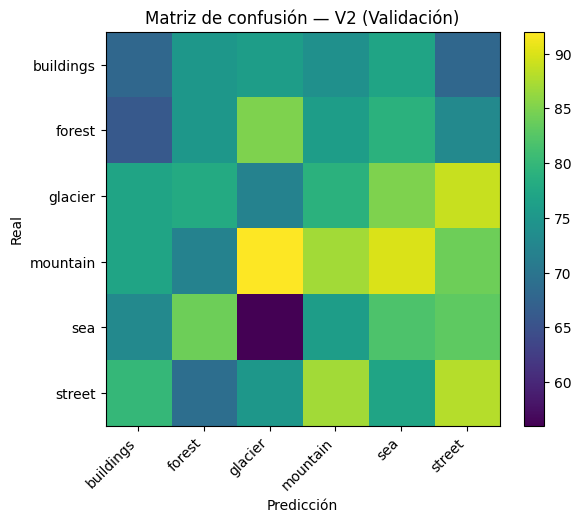


V3 (Validación)
              precision    recall  f1-score   support

   buildings       0.94      0.92      0.93       438
      forest       0.97      0.98      0.98       454
     glacier       0.82      0.86      0.84       480
    mountain       0.87      0.84      0.85       502
         sea       0.95      0.92      0.94       454
      street       0.92      0.94      0.93       476

    accuracy                           0.91      2804
   macro avg       0.91      0.91      0.91      2804
weighted avg       0.91      0.91      0.91      2804



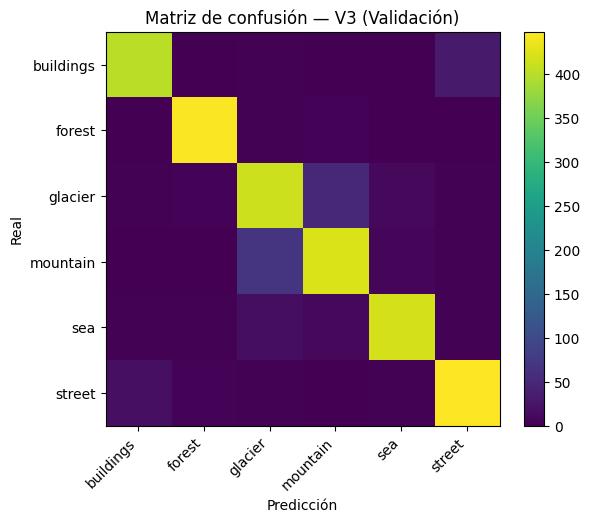


=== Comparativa VALIDACIÓN ===


,model,accuracy,samples
2,V3 (Validación),0.909415,2804
0,V1 (Validación),0.170827,2804
1,V2 (Validación),0.168331,2804



=== Comparativa TEST ===


,model,loss,accuracy,samples
1,V3 (Test),0.236663,0.913333,3000
0,V2 (Test),0.417785,0.852000,3000


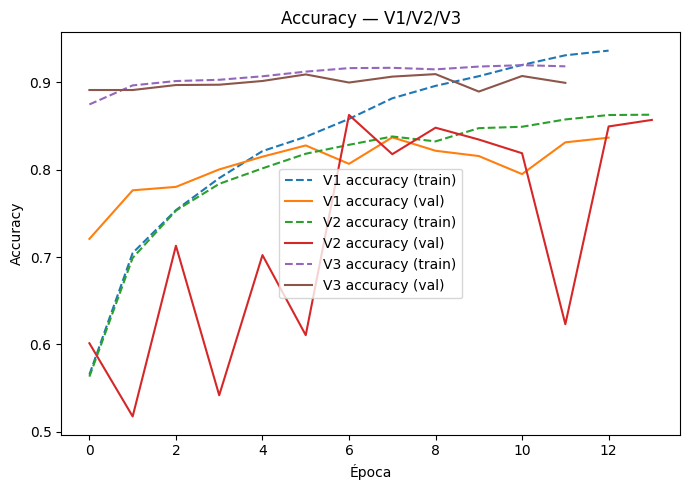

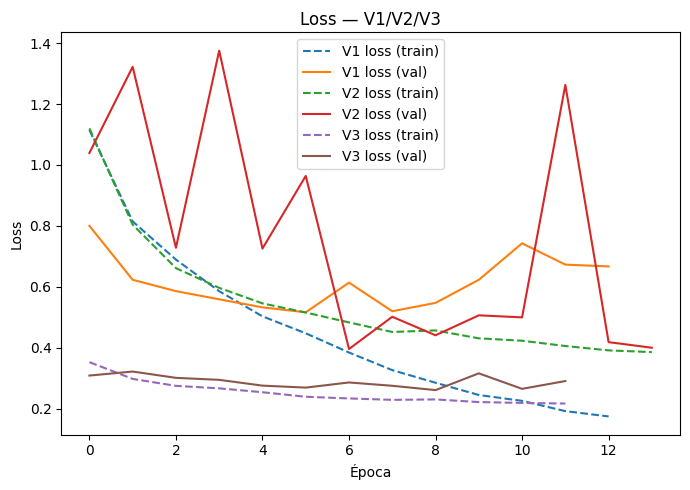

In [ ]:
# Evaluación unificada V1 / V2 / V3
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

# Evaluación detallada
def evaluate_and_report(model, generator, title='Evaluación'):
    """Imprime classification_report + matriz de confusión y devuelve dict con métricas agregadas."""
    y_true = generator.classes
    class_names = list(generator.class_indices.keys())

    y_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    print(f"\n{title}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Matriz de confusión — {title}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.xlabel('Predicción'); plt.ylabel('Real')
    plt.show()

    acc = (y_true == y_pred).mean()
    return {"model": title, "accuracy": float(acc), "samples": int(len(y_true))}

def eval_on_test(model, test_gen, title='(Test)'):
    """Devuelve loss/accuracy en test mediante model.evaluate."""
    loss, acc = model.evaluate(test_gen, verbose=0)
    return {"model": title, "loss": float(loss), "accuracy": float(acc), "samples": int(test_gen.n)}

try:
    test_gen_150
except NameError:
    test_gen_150 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        TEST_DIR, target_size=IMG_SIZE_V1V2, batch_size=BATCH_SIZE,
        class_mode="categorical", shuffle=False
    )

try:
    test_gen_224
except NameError:
    test_gen_224 = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
        TEST_DIR, target_size=IMG_SIZE_V3, batch_size=BATCH_SIZE,
        class_mode="categorical", shuffle=False
    )

# Validación
results = []
results.append(evaluate_and_report(model_v1, val_gen_v1, title='V1 (Validación)'))   # 150×150
results.append(evaluate_and_report(model_v2, val_gen_v2, title='V2 (Validación)'))   # 150×150

has_v3 = False
try:
    results.append(evaluate_and_report(model_v3, val_gen_v3, title='V3 (Validación)'))
    has_v3 = True
except NameError:
    print("Aviso: model_v3 no está definido todavía. Se omite V3 en validación.")
except Exception as e:
    print("Aviso: no se pudo evaluar V3 en validación:", e)

# Testeo
test_rows = []

test_rows.append(eval_on_test(model_v2, test_gen_150,  title='V2 (Test)'))  # 150×150
if has_v3:
    test_rows.append(eval_on_test(model_v3, test_gen_224, title='V3 (Test)'))  # 224×224

# Tablas resumen
df_val = pd.DataFrame(results)
df_test = pd.DataFrame(test_rows) if len(test_rows) else pd.DataFrame()

print("\n=== Comparativa VALIDACIÓN ===")
display(df_val.sort_values("accuracy", ascending=False))

if len(df_test):
    print("\n=== Comparativa TEST ===")
    display(df_test.sort_values("accuracy", ascending=False))

# Gráficas de curvas de entrenamiento
def plot_histories(histories, metric='accuracy', title='Curvas de entrenamiento'):
    plt.figure(figsize=(7,5))
    for label, h in histories:
        if metric in h.history:
            plt.plot(h.history[metric], label=f'{label} {metric} (train)', linestyle='--')
        val_key = f'val_{metric}'
        if val_key in h.history:
            plt.plot(h.history[val_key], label=f'{label} {metric} (val)')
    plt.xlabel('Época'); plt.ylabel(metric.capitalize())
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

histories = []
for name, hist in (("V1", 'history_v1'), ("V2", 'history_v2'), ("V3", 'history_v3')):
    try:
        histories.append((name, eval(hist)))
    except NameError:
        pass

if histories:
    plot_histories(histories, metric='accuracy', title='Accuracy — V1/V2/V3')
    plot_histories(histories, metric='loss',     title='Loss — V1/V2/V3')


## 11. Aplicación — Predicción de imagen nueva

Función para probar el modelo con una imagen individual.


Se mostrarán las predicciones de los modelos V3 y V2 comenzando por el que tuvo mejor desempeño. Considerando claro las imágenes en un tamaño de 244x244.

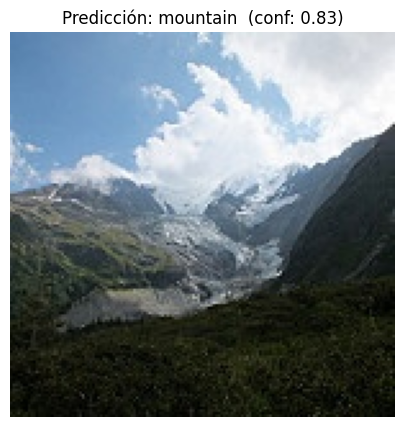

Top-3 probabilidades:
  mountain    0.830
  glacier     0.170
  sea         0.000

Imagen usada: data\seg_test\glacier\21102.jpg


In [ ]:
# Predicción de imagen nueva (Modelo V3 - ResNet50)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import json, random, os

# Rutas
SEG_PRED_DIR = DATASET_BASE / "seg_pred"
MODEL_V3_PATH = MODELS_DIR / "model_v3_best.keras"  

try:
    model_v3
except NameError:
    from keras.models import load_model
    model_v3 = load_model(MODEL_V3_PATH)

# Mapeo de clases
try:
    class_indices = train_gen_v3.class_indices
except NameError:
    # Carga desde labels.json
    labels_path = Path("labels.json")
    if labels_path.exists():
        with open(labels_path, "r", encoding="utf-8") as f:
            idx_to_class = json.load(f)       
            idx_to_class = {int(k): v for k, v in idx_to_class.items()}
    else:
        classes = sorted([d for d in os.listdir(TRAIN_DIR) if (TRAIN_DIR/d).is_dir()])
        idx_to_class = {i: c for i, c in enumerate(classes)}
else:
    idx_to_class = {v: k for k, v in class_indices.items()}  # {idx: class}

# Función de predicción para V3
def predict_image_v3(img_path, model, target_size=(224, 224), top_k=3):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  
    prob = model.predict(x, verbose=0)[0]  # vector de probabilidades
    pred_idx = int(np.argmax(prob))
    # Top-k
    top_indices = np.argsort(prob)[::-1][:top_k]
    top = [(idx_to_class[i], float(prob[i])) for i in top_indices]
    return idx_to_class[pred_idx], float(prob[pred_idx]), top

# Tomar una imagen de seg_pred 
candidates = []
if SEG_PRED_DIR.exists():
    candidates = [p for p in SEG_PRED_DIR.glob("*") if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}]
if not candidates:
    candidates = [p for p in (TEST_DIR).rglob("*") if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}]

assert len(candidates) > 0, "No se encontraron imágenes en seg_pred/ ni en seg_test/"

img_path = random.choice(candidates)
pred_label, pred_conf, top3 = predict_image_v3(img_path, model_v3, target_size=(224,224))

# Mostrar imagen + predicción
plt.figure(figsize=(5,5))
plt.imshow(Image.open(img_path).convert("RGB"))
plt.axis("off")
plt.title(f"Predicción: {pred_label}  (conf: {pred_conf:.2f})")
plt.show()

print("Top-3 probabilidades:")
for cls, p in top3:
    print(f"  {cls:10s}  {p:.3f}")
print("\nImagen usada:", img_path)


En este segundo modelo se realiza el mismo procedimiento pero con el tamaño de imagen de 150x150

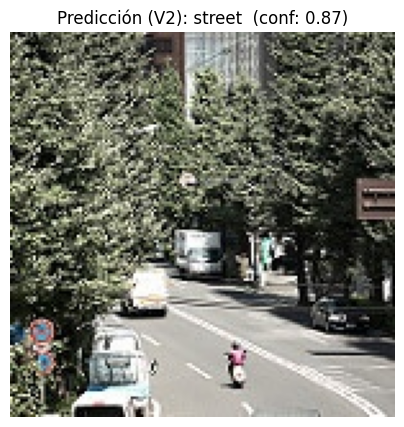

Top-3 probabilidades (V2):
  street      0.870
  forest      0.066
  buildings   0.055

Imagen usada: data\seg_test\street\23471.jpg


In [68]:
# Predicción con MODELO V2 (CNN personalizada)

# Carpeta de predicción
SEG_PRED_DIR = DATASET_BASE / "seg_pred"

# Cargar modelo V2 si no está en memoria
MODEL_V2_PATH = MODELS_DIR / "model_v2_final.keras"
try:
    model_v2
except NameError:
    from tensorflow.keras.models import load_model
    model_v2 = load_model(MODEL_V2_PATH)

# Cargar labels
labels_path = Path("labels.json")
if labels_path.exists():
    with open(labels_path, "r", encoding="utf-8") as f:
        idx_to_class = json.load(f)
        idx_to_class = {int(k): v for k, v in idx_to_class.items()}
else:
    classes = sorted([d for d in os.listdir(TRAIN_DIR) if (TRAIN_DIR/d).is_dir()])
    idx_to_class = {i: c for i, c in enumerate(classes)}

# Función para predecir con V2
def predict_image_v2(img_path, model, target_size=(150,150), top_k=3):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)/255.0
    x = np.expand_dims(x, axis=0)
    prob = model.predict(x, verbose=0)[0]
    
    pred_idx = int(np.argmax(prob))
    top_indices = np.argsort(prob)[::-1][:top_k]
    top = [(idx_to_class[i], float(prob[i])) for i in top_indices]
    return idx_to_class[pred_idx], float(prob[pred_idx]), top

# Buscar imagen en seg_pred
candidates = []
if SEG_PRED_DIR.exists():
    candidates = [p for p in SEG_PRED_DIR.glob("*") if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}]

if not candidates:
    candidates = [p for p in TEST_DIR.rglob("*") if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}]

assert len(candidates) > 0, "No se encontraron imágenes en seg_pred ni en seg_test"

img_path = random.choice(candidates)
pred_label, pred_conf, top3 = predict_image_v2(img_path, model_v2)

# Mostrar resultado
plt.figure(figsize=(5,5))
plt.imshow(Image.open(img_path).convert("RGB"))
plt.axis("off")
plt.title(f"Predicción (V2): {pred_label}  (conf: {pred_conf:.2f})")
plt.show()

print("Top-3 probabilidades (V2):")
for cls, p in top3:
    print(f"  {cls:10s}  {p:.3f}")

print("\nImagen usada:", img_path)


## Conclusiones

Se evaluaron tres modelos para la clasificación de escenas: una CNN base (V1), una CNN mejorada con squeze and excitation (V2) y un modelo con Transfer Learning usando ResNet50 (V3). Los resultados muestran diferencias claras en capacidad de aprendizaje y generalización.

**V1 – Modelo Base (CNN desde cero):**
Actuó solo como referencia, ya que obtuvo una precisión de validación cercana a 0.17. Es prácticamente una selección aleatoria entre las 3 clases. La pérdida de validación no mejoró y la matriz de confusión muestra clasificaciones prácticamente uniformes. Lo que podemos decir es que el modelo no logró aprender patrones visuales relevantes.

**V2 – CNN con bloques Squeeze-and-Excitation, Batch Normalization, Dropout:**
Aunque mejoró la estabilidad respecto a V1, su precisión también quedó en 0.17 en validación y las predicciones siguieron siendo casi aleatorias. Sin embargo, en test alcanzó 0.85, pero con variaciones fuertes entre clases. Lo que se logró fue tener una mejor regularización, pero insuficiente para la complejidad del dataset. Lo que nos lleva a la última implementación.

**V3 – Transfer Learning con ResNet50 (Mejor Modelo):**
Fue el único modelo que realmente aprendió las diferencias entre clases. Alcanzó 0.91 de accuracy en validación y 0.91 en test, con F1-scores superiores al 80% en todas las categorías. La matriz de confusión muestra una diagonal clara, indicando una clasificación consistente. Además, las curvas de pérdida y accuracy se mantuvieron estables sin sobreajuste.

Con ello podemos decir que los modelos pequeños (V1 y V2) no lograron capturar patrones visuales complejos. En cambio, ResNet50 aprovechó el conocimiento preentrenado en ImageNet y permitió una clasificación precisa y generalizable. Por su estabilidad y más de 90% de exactitud, el modelo V3 es el más adecuado para aplicación real y despliegue. Esto queda más que comprobado en la implementación de predicción con las diferentes imágenes.